# Spot the Mask Challenge

Objectif: construire une démarche scientifique et montrer ce qui a marché et ce qui n'a pas marché. Essayer de proposer quelquechose qui fonctionne et qui utilise des idées interessantes.




#### Protocole:


On experimente une technique.
On la commente.
On conclut.
Utiliser un modèle de base, un modèle de ref ?



## Ideas:

Globalement c'est du transfert learning.
Et k-fold

### Exploration des données:

- Afficher les images.
- Et faire des statistiques basiques sur les classes.

### Training:
- Transfer learning (mais pas que ? on peut en faire un sans et montre que le TL améliore les perfs, toutes choses étant égales par ailleurs ?)
- Voir les architectures de réseau que l'on veut tester
- Voir les idées proposées et vues en cours !
- Regularisation l1 l2 etc.
- ResNet
- Early Stopping
- Adversarial Training

- Ya pas mal d'idées qui viennent de l'article Medium qui est écrit par quelqu'un qui à l'air très bon que je voudrais implémenter.
- J'aimerais bien tester les méthodes proposées dans l'article ?

### Overfitting:
- Dropout
- K-fold

### Data augmentation:

- Générer de nouveaux exemples grace à des adversarial attacks ?
- Utiliser les GAN pour augmenter la donnée ?
- Crop et techniques classiques ?


### Remarques:
- Commenter son code, et rédiger l'approche. (Anglais c'est mieux, au pire je passerais au traducteur etc.)

- Citer les sources, c'est préférable.

## Sources intéressantes
- Latest Winning Techniques for Kaggle Image Classification with Limited Data: 

https://towardsdatascience.com/latest-winning-techniques-for-kaggle-image-classification-with-limited-data-5259e7736327

- Building powerful image classification models using very little data

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html


## Import and data loading

In [ ]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random
import os

from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive


matplotlib.style.use('dark_background')
# Set the random seed
seed = 94

# The below function will be called each time we evaluate a new model
def reset_random_seeds():
   os.environ['PYTHONHASHSEED'] = str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   random.seed(seed)

# Mount
drive.mount('/content/drive')

# Move to folder in personal drive in order to work in this location
project_path = '/content/drive/My Drive/m2_iasd/deep_images'
image_folder = 'data/'
os.chdir(project_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Comments

- In this notebook we always try to set seeds in order to have reproducible results when computing multiple models.

## Data extraction

In this part we extract the data from the zip file and store it into a directory.

In [ ]:
# Run this cell only once to unzip data / make directory
"""
import zipfile

# Unzip provided folder containing data
zipped_file = 'Dauphine_Projet_Image2020-20200519T130341Z-001.zip'
with zipfile.ZipFile(zipped_file, 'r') as zip_ref:
  zip_ref.extractall('images')

"""

In [ ]:
# Run this cell only once to setup data and directories
"""
import shutil

# Sort the images and move them into new into new dedicated folders

image_folder = 'data/'

# Store images in the following folder
os.makedirs(image_folder)

for image in os.listdir():
  image = image.strip()
  suffixes = ('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')
  # Moving images
  if image.endswith(suffixes):
    shutil.move(image, 'data/')
"""

### Comments

- A folder containing all the images is created, the basic workflow used in this notebook is to use **Keras image preprocessing API** to get image batches directly from the mounted drive directory.


## Data exploration

In this part we will try to understand the data by computing basic statistics.

In [ ]:
# Change working directory and read label data
path = project_path + '/images/Dauphine_Projet_Image2020'
os.chdir(path)

df_images = pd.read_csv('train_labels.csv')

df_images['image'] = df_images['image'].apply(lambda x: x.strip())
# Cast to string as required by the image API
df_images.target = df_images.target.astype(str)

In [ ]:
df_images.head()

,image,target
0,tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0
1,rxgismgsvmaayzjarbfjaljhqmpbrt.jpg,1
2,uuzshfrhkgrkolhwdvliqauzulurnz.jpg,0
3,mjspxsagzusaznvnyxgamtrlqkqklp.jpg,0
4,rlbmuajgezfiddjzlyeoupxpqubkpt.jpg,1


### Class distribution

Observing how balanced is the training set.

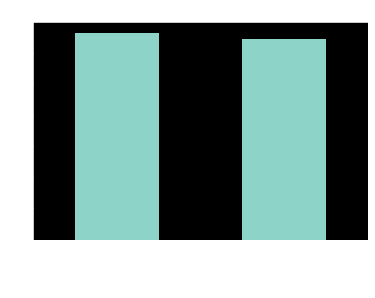

In [ ]:
# Class distribution
(df_images
 .target
 .replace({'0':'no_mask', '1':'mask'})
 .value_counts()
 .plot
 .bar(title='Class repartition in the dataset')
 )

Found 1817 images belonging to 1 classes.


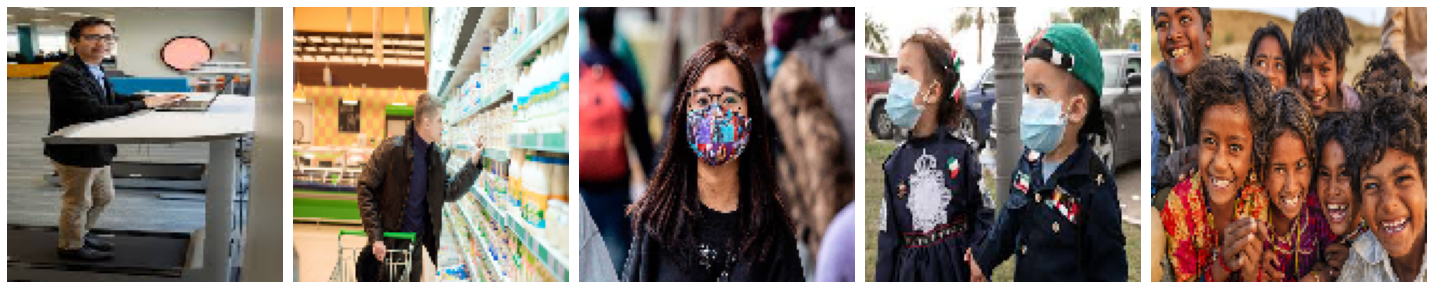

In [ ]:
# Now we plot our data, the below generator is used only here !
image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # Generator for our training data

batch_generator = image_generator.flow_from_directory(batch_size=5,
                                    directory='.',
                                    shuffle=True,
                                    target_size=(128, 128),
                                    class_mode='binary')

sample_training_images, _ = next(batch_generator)

def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(sample_training_images[:5])

### Image shape

Images not seem to have a uniform shape, let's check the shapes distribution.

In [ ]:
import cv2 as cv

# Get image shapes distribution, we will not go

list_shapes = []

for image_name in os.listdir(image_folder):
  image = cv.imread(image_folder + image_name)
  list_shapes.append(image.shape)

df_shapes = pd.DataFrame(data=list_shapes,
                         columns=['width', 'height', 'channel'])
df_shapes.describe()

,width,height,channel
count,1817.000000,1817.00000,1817.0
mean,446.818932,624.73803,3.0
std,367.868757,517.98783,0.0
min,110.000000,115.00000,3.0
25%,194.000000,275.00000,3.0
50%,350.000000,474.00000,3.0
75%,563.000000,800.00000,3.0
max,3642.000000,4698.00000,3.0


Text(0.5, 1.0, 'Width/Height distribution')

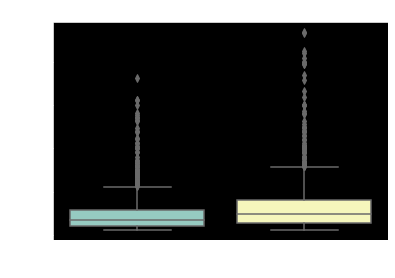

In [ ]:
df = \
(df_shapes
 .drop(columns='channel')
 .melt(var_name='dimension'))

sns.boxplot(x="dimension", y="value", data=df).set_title('Width/Height distribution')

Text(0.5, 1.0, 'Aspect ratio distribution')

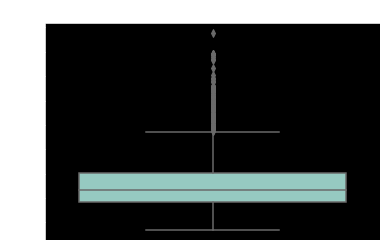

In [ ]:
df = \
(df_shapes.assign(aspect_ratio=df_shapes.width / df_shapes.height)
 .aspect_ratio
 .to_frame())

sns.boxplot(y="aspect_ratio", data=df).set_title('Aspect ratio distribution')

### Comments

- The small amount of data suggest using **transfer learning** to achieve the classification task
- **Data augmentation** should also be used to avoid overfitting.
- Classic image transformation can be use, we would also try adversarial training (cf. class lesson) as an data augmentation proxy.
- **Cross-validation** might be interesting to reduce variance of our results.
- Learning rate magnitude should be relatively small to obtain a stable learning.

## Learning a model for face mask recognition

We use features learnt by the ResNet pre-trained model to teach our model to recognize face masks.

We use 3 folds (cross-validation) otherwise the execution time is too large for our experiments.

In [ ]:
# Dictionnary containing all model statistics, it saves every training.
dict_models = {}

### Learning rate analysis

In [ ]:
# Cross-validation with TF image API
import sklearn.model_selection
from tensorflow import keras
from tensorflow.keras import layers

n_folds = 3
kf = sklearn.model_selection.KFold(n_splits=n_folds, random_state=seed)
kf.split(df_images)

list_parameters = [0.0001, 0.00001]
model_names = [f'learning_rate_{x}' for x in list_parameters]

list_histories = []

image_folder = 'data/'
img_width, img_height = 256, 256

epochs = 40
batch_size = 32

for i, model_name in enumerate(model_names):

  # Define loss and optimizer
  loss = keras.losses.BinaryCrossentropy(from_logits=True)
  learning_rate = list_parameters[i]
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  print(f'Training model: {model_name}')
  list_histories = []
  for train_index, test_index in kf.split(df_images):

    # --- Data processing ---

    df_train = df_images.iloc[train_index]
    df_test = df_images.iloc[test_index]
    print('Train shape:', df_train.shape)
    print('Test shape:', df_test.shape)
    
    train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                preprocessing_function=tf.keras.applications.resnet.preprocess_input)
    validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                      preprocessing_function=tf.keras.applications.resnet.preprocess_input)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=image_folder,
        x_col="image",
        y_col="target",
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
        class_mode="binary",
        target_size=(img_width, img_height))

    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=image_folder,
        x_col="image",
        y_col="target",
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
        class_mode="binary",
        target_size=(img_width, img_height))
    
    # --- Model architecture ---

    # Reset graph and seeds
    tf.keras.backend.clear_session()
    reset_random_seeds()

    # Create the base model from the pre-trained model ResNet50
    base_model = tf.keras.applications.ResNet101(
        # input_shape=(128, 128, 3),
                                                  include_top=True,
                                                  weights='imagenet')
    base_model.trainable = True

    head = layers.Flatten()(base_model.output)
    head = layers.Dense(256, kernel_initializer=keras.initializers.glorot_uniform(seed=seed))(head)
    head = layers.Activation('relu')(head)
    # head = layers.Dropout(rate=0.5)(head)

    head = layers.Dense(64, kernel_initializer=keras.initializers.glorot_uniform(seed=seed))(head)
    head = layers.Activation('relu')(head)

    output = layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=seed))(head)
    model = keras.Model(inputs=base_model.inputs, outputs=output)

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    

    nb_train_samples = len(df_train.index)
    nb_validation_samples = len(df_test.index)


    history = model.fit(
      train_generator,
      steps_per_epoch=nb_train_samples // batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=nb_validation_samples // batch_size)
    
    # Append historical training stats
    list_histories.append(history.history)
  # Add it to the dictionnary
  dict_models[model_name] = list_histories
  # Add the last model (could be improved) to the dictionnary
  dict_models[f'{model_name}_model'] = model

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Training model: learning_rate_0.0001
Train shape: (872, 2)
Test shape: (436, 2)
Found 872 validated image filenames belonging to 2 classes.
Found 436 validated image filenames belonging to 2 classes.
Epoch 1/40
27/27 [==============================] - 17s 621ms/step - loss: 0.6783 - accuracy: 0.4976 - val_loss: 0.6928 - val_accuracy: 0.5312
Epoch 2/40
27/27 [==============================] - 15s 561ms/step - loss: 0.6356 - accuracy: 0.4964 - val_loss: 0.6928 - val_accuracy: 0.5264
Epoch 3/40
27/27 [==============================] - 15s 563ms/step - loss: 0.5841 - accuracy: 0.5000 - val_loss: 0.6958 - val_accuracy: 0.5192
Epoch 4/40
27/27 [==============================] - 15s 548ms/step - loss: 0.5319 - accuracy: 0.7917 - val_loss: 0.7526 - val_accuracy: 0.4856
Epoch 5/40
27/27 [==============================] - 15s 564ms/step - loss: 0.4756 - accuracy: 0.9405 - val_loss: 0.7953 - val_accuracy: 0.4808
Epoch 6/40
27/27 [==============================] - 15s 539ms/step - loss: 0.4171 - a

In [ ]:
# Aggregate all training statisctics !
df = pd.concat(
  [pd.concat([pd.DataFrame(history)
              for history in dict_models[model_name]],
             keys=[f'fold_{i}' for i in range(n_folds)])
   for model_name in model_names],
  keys=model_names)

# Reshaping DataFrame to plot confidence intervals
df =\
(df
  .reset_index()
  .rename(columns={"level_0": "model_name",
                   "level_1": "fold",
                   "level_2": "epochs"},)
  .drop(columns=['fold'])
  .melt(['model_name', 'epochs'],
        var_name='metric_type',
        value_name='value')
  .assign(data_type=lambda s: s.metric_type.map(lambda x: 'validation'
                                              if x.split('_')[0] == 'val' else
                                              'train'))
  .assign(metric_type=lambda s: s.metric_type.str.replace('val_', '')))

df.sample(frac=1).head(10)

,model_name,epochs,metric_type,value,data_type
152,learning_rate_1e-05,32,loss,0.476080,train
548,learning_rate_0.0001,28,loss,0.777610,validation
704,learning_rate_1e-05,24,loss,0.519601,validation
361,learning_rate_1e-05,1,accuracy,0.496429,train
151,learning_rate_1e-05,31,loss,0.482426,train
335,learning_rate_0.0001,15,accuracy,0.989286,train
397,learning_rate_1e-05,37,accuracy,0.994048,train
402,learning_rate_1e-05,2,accuracy,0.508333,train
835,learning_rate_0.0001,35,accuracy,0.853365,validation
30,learning_rate_0.0001,30,loss,0.042357,train


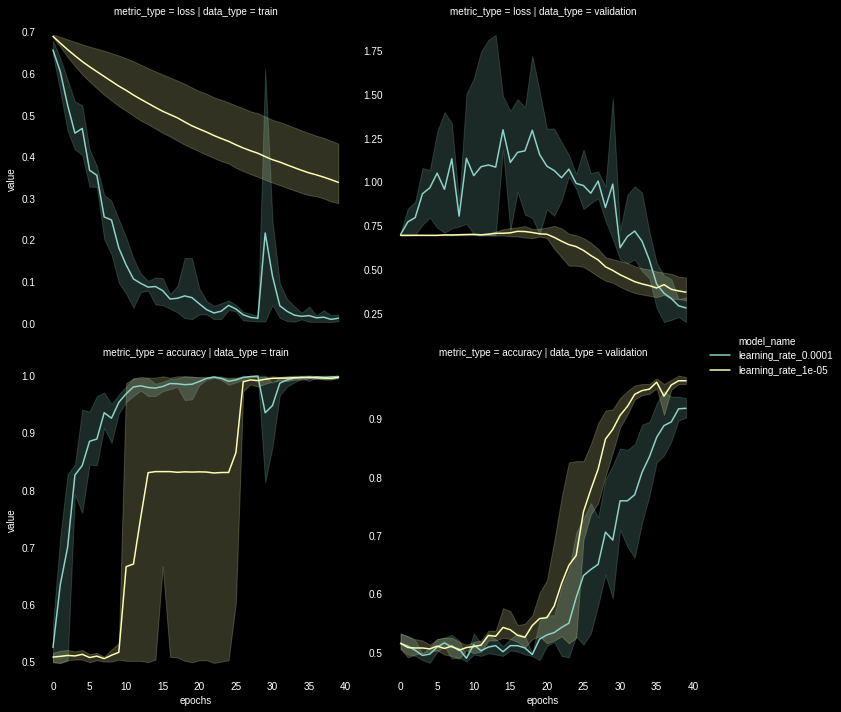

In [ ]:
# Plot training stats with confidence intervals

sns.relplot(x="epochs", y="value",
            col="data_type", row='metric_type', hue="model_name",
            kind="line", data=df , facet_kws={'sharey': False, 'sharex': True})

In [ ]:
(df
 .loc[df.epochs.eq(epochs - 1), :]
 .groupby(['metric_type', 'model_name', 'data_type'])
 .mean())

epochs     value
metric_type model_name           data_type                   
accuracy    learning_rate_0.0001 train           39  0.998413
                                 validation      39  0.917468
            learning_rate_1e-05  train           39  0.996825
                                 validation      39  0.964744
loss        learning_rate_0.0001 train           39  0.011142
                                 validation      39  0.278279
            learning_rate_1e-05  train           39  0.337552
                                 validation      39  0.368232

### Comments

- The learning_rate_1e-05 learning rate model has a better validation accuracy 96% than the other model 91%.

- There is almost 5 percentage points differencing both models.

- This experience also shows small gradient steps improve learning stability (the curve is less volatile for the lowest learning rate).

### Dropout

In this part, two techniques are used in order to reduce overfitting: **dropout** and **regularization**.


In [ ]:
# Cross-validation with TF image API
import sklearn.model_selection
from tensorflow import keras
from tensorflow.keras import layers

n_folds = 3
kf = sklearn.model_selection.KFold(n_splits=n_folds, random_state=seed)
kf.split(df_images)

model_names = ['dropout', 'dropout_regularizer']

list_histories = []

image_folder = 'data/'
img_width, img_height = 256, 256

epochs = 40
batch_size = 32

for i, model_name in enumerate(model_names):

  # Define loss and optimizer
  loss = keras.losses.BinaryCrossentropy(from_logits=True)

  learning_rate = 0.00001
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  print(f'Training model: {model_name}')
  list_histories = []

  for train_index, test_index in kf.split(df_images):

    # --- Data processing ---

    df_train = df_images.iloc[train_index]
    df_test = df_images.iloc[test_index]
    print('Train shape:', df_train.shape)
    print('Test shape:', df_test.shape)
    
    train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                preprocessing_function=tf.keras.applications.resnet.preprocess_input)
    validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                      preprocessing_function=tf.keras.applications.resnet.preprocess_input)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=image_folder,
        x_col="image",
        y_col="target",
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
        class_mode="binary",
        target_size=(img_width, img_height))

    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=image_folder,
        x_col="image",
        y_col="target",
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
        class_mode="binary",
        target_size=(img_width, img_height))
    
    # --- Model architecture ---

    # Reset graph and seeds
    tf.keras.backend.clear_session()
    reset_random_seeds()

    # Create the base model from the pre-trained model ResNet50
    base_model = tf.keras.applications.ResNet101(
        # input_shape=(128, 128, 3),
                                                  include_top=True,
                                                  weights='imagenet')
    base_model.trainable = True

    head = layers.Flatten()(base_model.output)
    if model_name == 'dropout_regularizer':
      head = layers.Dense(256,
                    kernel_initializer=keras.initializers.glorot_uniform(seed=seed),
                    kernel_regularizer=keras.regularizers.l2(0.0005))(head)
    else:
      head = layers.Dense(256,
                    kernel_initializer=keras.initializers.glorot_uniform(seed=seed))(head)

    head = layers.Activation('relu')(head)
    head = layers.Dropout(rate=0.5, seed=seed)(head)

    if model_name == 'dropout_regularizer':
      head = layers.Dense(64,
                          kernel_initializer=keras.initializers.glorot_uniform(seed=seed),
                          kernel_regularizer=keras.regularizers.l2(0.0005))(head)
    else:
      head = layers.Dense(64,
                    kernel_initializer=keras.initializers.glorot_uniform(seed=seed))(head)

    head = layers.Activation('relu')(head)
    head = layers.Dropout(rate=0.5, seed=seed)(head)

    output = layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=seed))(head)
    model = keras.Model(inputs=base_model.inputs, outputs=output)

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    

    nb_train_samples = len(df_train.index)
    nb_validation_samples = len(df_test.index)


    history = model.fit(
      train_generator,
      steps_per_epoch=nb_train_samples // batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=nb_validation_samples // batch_size)
    
    # Append historical training stats
    list_histories.append(history.history)
  # Add it to the dictionnary
  dict_models[model_name] = list_histories
  # Add the last model (could be improved) to the dictionnary
  dict_models[f'{model_name}_model'] = model

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Training model: dropout
Train shape: (872, 2)
Test shape: (436, 2)
Found 872 validated image filenames belonging to 2 classes.
Found 436 validated image filenames belonging to 2 classes.
Epoch 1/40
27/27 [==============================] - 17s 620ms/step - loss: 0.6924 - accuracy: 0.4976 - val_loss: 0.6932 - val_accuracy: 0.5312
Epoch 2/40
27/27 [==============================] - 15s 563ms/step - loss: 0.6896 - accuracy: 0.4964 - val_loss: 0.6933 - val_accuracy: 0.5264
Epoch 3/40
27/27 [==============================] - 15s 555ms/step - loss: 0.6863 - accuracy: 0.5012 - val_loss: 0.6934 - val_accuracy: 0.5216
Epoch 4/40
27/27 [==============================] - 15s 568ms/step - loss: 0.6814 - accuracy: 0.5024 - val_loss: 0.6935 - val_accuracy: 0.5192
Epoch 5/40
27/27 [==============================] - 15s 556ms/step - loss: 0.6784 - accuracy: 0.5024 - val_loss: 0.6935 - val_accuracy: 0.5120
Epoch 6/40
27/27 [==============================] - 15s 543ms/step - loss: 0.6745 - accuracy: 0.49

In [ ]:
dict_models.keys()

dict_keys(['learning_rate_0.0001', 'learning_rate_0.0001_model', 'learning_rate_1e-05', 'learning_rate_1e-05_model', 'dropout', 'dropout_model', 'dropout_regularizer', 'dropout_regularizer_model'])

In [ ]:
# Aggregate all training statisctics !
model_names.append('learning_rate_1e-05')

df = pd.concat(
  [pd.concat([pd.DataFrame(history)
              for history in dict_models[model_name]],
             keys=[f'fold_{i}' for i in range(n_folds)])
   for model_name in model_names],
  keys=model_names)

# Reshaping DataFrame to plot confidence intervals
df =\
(df
  .reset_index()
  .rename(columns={"level_0": "model_name",
                   "level_1": "fold",
                   "level_2": "epochs"},)
  .drop(columns=['fold'])
  .melt(['model_name', 'epochs'],
        var_name='metric_type',
        value_name='value')
  .assign(data_type=lambda s: s.metric_type.map(lambda x: 'validation'
                                              if x.split('_')[0] == 'val' else
                                              'train'))
  .assign(metric_type=lambda s: s.metric_type.str.replace('val_', '')))

df.sample(frac=1).head(10)

,model_name,epochs,metric_type,value,data_type
1032,learning_rate_1e-05,32,loss,0.404393,validation
221,dropout_regularizer,21,loss,0.668444,train
162,dropout_regularizer,2,loss,0.900945,train
1288,dropout_regularizer,8,accuracy,0.492788,validation
259,learning_rate_1e-05,19,loss,0.565355,train
1413,learning_rate_1e-05,13,accuracy,0.524038,validation
1050,learning_rate_1e-05,10,loss,0.702454,validation
30,dropout,30,loss,0.557099,train
31,dropout,31,loss,0.556122,train
3,dropout,3,loss,0.681428,train


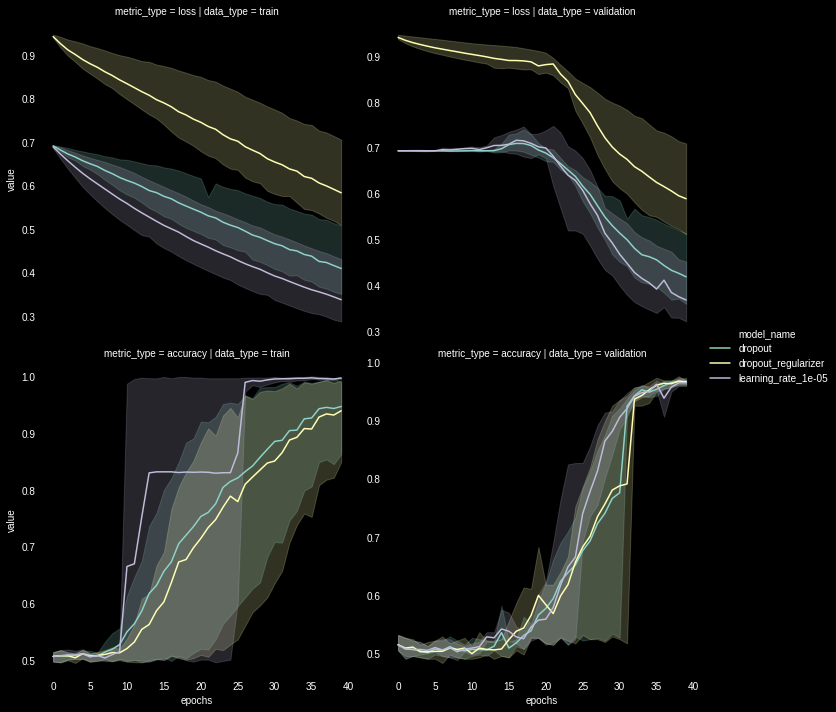

In [ ]:
# Plot training stats with confidence intervals

sns.relplot(x="epochs", y="value",
            col="data_type", row='metric_type', hue="model_name",
            kind="line", data=df , facet_kws={'sharey': False, 'sharex': True})

In [ ]:
(df
 .loc[df.epochs.eq(epochs - 1), :]
 .groupby(['metric_type', 'model_name', 'data_type'])
 .mean())

epochs     value
metric_type model_name          data_type                   
accuracy    dropout             train           39  0.946825
                                validation      39  0.967147
            dropout_regularizer train           39  0.939286
                                validation      39  0.966346
            learning_rate_1e-05 train           39  0.996825
                                validation      39  0.964744
loss        dropout             train           39  0.409319
                                validation      39  0.418715
            dropout_regularizer train           39  0.583166
                                validation      39  0.588773
            learning_rate_1e-05 train           39  0.337552
                                validation      39  0.368232

### Comments

- Dropout on last layers does not improve performances. Indeed, last layers are unlikely responsible of overfitting !

- Same observation for regularization, the fresh layers are not responsible for overfitting, but it is the whole network that is able to remember the data since the parameter space is huge. The regularisation should be applied to higher layers (indeed the tensorflow API add regularization that is layer-dependant).

### Parameters freezing, data augmentation and batch norm

In [ ]:
# Cross-validation with TF image API
import sklearn.model_selection
from tensorflow import keras
from tensorflow.keras import layers

n_folds = 3
kf = sklearn.model_selection.KFold(n_splits=n_folds, random_state=seed)
kf.split(df_images)

model_names = ['freezed', 'augmented_data', 'batch_normalisation']

list_histories = []

image_folder = 'data/'
img_width, img_height = 256, 256

epochs = 40
batch_size = 32

for i, model_name in enumerate(model_names):

  # Define loss and optimizer
  loss = keras.losses.BinaryCrossentropy(from_logits=True)

  learning_rate = 0.00001
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  print(f'Training model: {model_name}')
  list_histories = []

  for train_index, test_index in kf.split(df_images):

    # --- Data processing ---

    df_train = df_images.iloc[train_index]
    df_test = df_images.iloc[test_index]
    print('Train shape:', df_train.shape)
    print('Test shape:', df_test.shape)
    
    if model_name == 'augmented_data':
      train_datagen = keras.preprocessing.image.ImageDataGenerator(
          rescale=1./255,
          rotation_range=40,
          width_shift_range=0.2,
          height_shift_range=0.2,
          shear_range=0.2,
          zoom_range=0.2,
          horizontal_flip=True,
          fill_mode='nearest',
          preprocessing_function=tf.keras.applications.resnet.preprocess_input)
    else:
      train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                preprocessing_function=tf.keras.applications.resnet.preprocess_input)
    validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                      preprocessing_function=tf.keras.applications.resnet.preprocess_input)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=image_folder,
        x_col="image",
        y_col="target",
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
        class_mode="binary",
        target_size=(img_width, img_height))

    validation_generator=validation_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=image_folder,
        x_col="image",
        y_col="target",
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
        class_mode="binary",
        target_size=(img_width, img_height))
    
    # --- Model architecture ---

    # Reset graph and seeds
    tf.keras.backend.clear_session()
    reset_random_seeds()

    # Create the base model from the pre-trained model ResNet50
    base_model = tf.keras.applications.ResNet101(
        # input_shape=(128, 128, 3),
                                                  include_top=True,
                                                  weights='imagenet')
    
    if model_name == 'freezed':
      base_model.trainable = False
    else:
      base_model.trainable = True


    head = layers.Flatten()(base_model.output)

    if model_name == 'dropout_regularizer':
      head = layers.Dense(256,
                    kernel_initializer=keras.initializers.glorot_uniform(seed=seed),
                    kernel_regularizer=keras.regularizers.l2(0.0005))(head)
    else:
      head = layers.Dense(256,
                    kernel_initializer=keras.initializers.glorot_uniform(seed=seed))(head)

    head = layers.Activation('relu')(head)
    if model_name == 'batch_normalisation':
      head = layers.BatchNormalization()(head)
    head = layers.Dropout(rate=0.5)(head)


    if model_name == 'dropout_regularizer':
      head = layers.Dense(64,
                          kernel_initializer=keras.initializers.glorot_uniform(seed=seed),
                          kernel_regularizer=keras.regularizers.l2(0.0005))(head)
    else:
      head = layers.Dense(64,
                    kernel_initializer=keras.initializers.glorot_uniform(seed=seed))(head)

    head = layers.Activation('relu')(head)
    if model_name == 'batch_normalisation':
      head = layers.BatchNormalization()(head)
    head = layers.Dropout(rate=0.5)(head)
    
    output = layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=seed))(head)
    model = keras.Model(inputs=base_model.inputs, outputs=output)

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    

    nb_train_samples = len(df_train.index)
    nb_validation_samples = len(df_test.index)


    history = model.fit(
      train_generator,
      steps_per_epoch=nb_train_samples // batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=nb_validation_samples // batch_size)
    
    # Append historical training stats
    list_histories.append(history.history)
  # Add it to the dictionnary
  dict_models[model_name] = list_histories
  # Add the last model (could be improved) to the dictionnary
  dict_models[f'{model_name}_model'] = model

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Training model: freezed
Train shape: (872, 2)
Test shape: (436, 2)
Found 872 validated image filenames belonging to 2 classes.
Found 436 validated image filenames belonging to 2 classes.
Epoch 1/40
27/27 [==============================] - 18s 650ms/step - loss: 0.6933 - accuracy: 0.4976 - val_loss: 0.6931 - val_accuracy: 0.5312
Epoch 2/40
27/27 [==============================] - 15s 574ms/step - loss: 0.6931 - accuracy: 0.4964 - val_loss: 0.6931 - val_accuracy: 0.5264
Epoch 3/40
27/27 [==============================] - 16s 589ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5240
Epoch 4/40
27/27 [==============================] - 15s 559ms/step - loss: 0.6936 - accuracy: 0.4952 - val_loss: 0.6932 - val_accuracy: 0.5144
Epoch 5/40
27/27 [==============================] - 16s 580ms/step - loss: 0.6932 - accuracy: 0.4964 - val_loss: 0.6931 - val_accuracy: 0.5264
Epoch 6/40
27/27 [==============================] - 16s 577ms/step - loss: 0.6932 - accuracy: 0.50

In [ ]:
# Aggregate all training statisctics !
df = pd.concat(
  [pd.concat([pd.DataFrame(history)
              for history in dict_models[model_name]],
             keys=[f'fold_{i}' for i in range(n_folds)])
   for model_name in model_names],
  keys=model_names)

# Reshaping DataFrame to plot confidence intervals
df =\
(df
  .reset_index()
  .rename(columns={"level_0": "model_name",
                   "level_1": "fold",
                   "level_2": "epochs"},)
  .drop(columns=['fold'])
  .melt(['model_name', 'epochs'],
        var_name='metric_type',
        value_name='value')
  .assign(data_type=lambda s: s.metric_type.map(lambda x: 'validation'
                                              if x.split('_')[0] == 'val' else
                                              'train'))
  .assign(metric_type=lambda s: s.metric_type.str.replace('val_', '')))

df.sample(frac=1).head(10)

,model_name,epochs,metric_type,value,data_type
1114,freezed,34,accuracy,0.519231,validation
1068,batch_normalisation,28,loss,0.372317,validation
1084,freezed,4,accuracy,0.526442,validation
225,augmented_data,25,loss,0.451732,train
153,augmented_data,33,loss,0.540566,train
1018,batch_normalisation,18,loss,0.765550,validation
751,freezed,31,loss,0.693051,validation
266,batch_normalisation,26,loss,0.191455,train
268,batch_normalisation,28,loss,0.189371,train
31,freezed,31,loss,0.692790,train


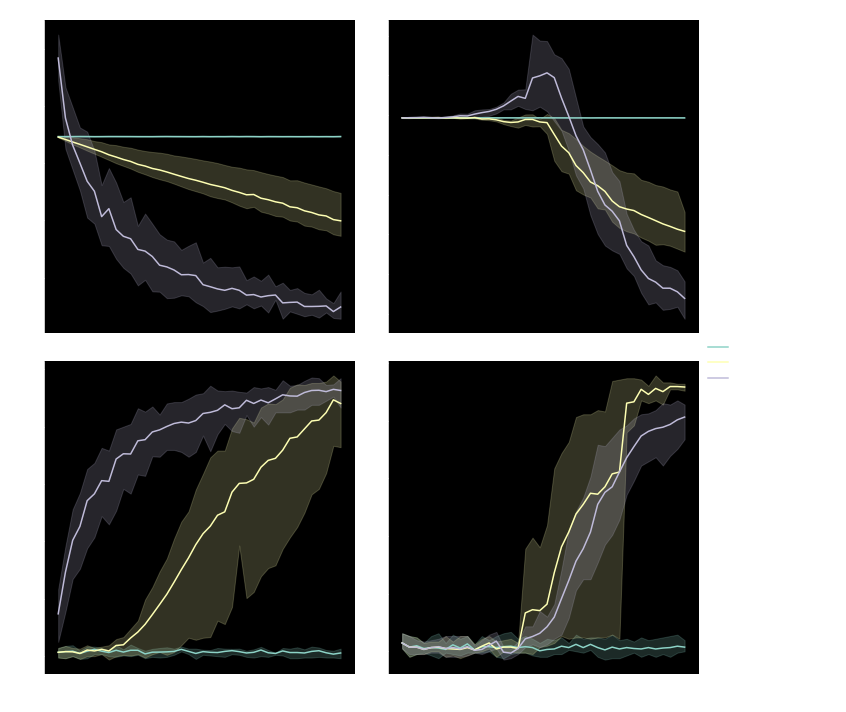

In [ ]:
# Plot training stats with confidence intervals

sns.relplot(x="epochs", y="value",
            col="data_type", row='metric_type', hue="model_name",
            kind="line", data=df , facet_kws={'sharey': False, 'sharex': True})

In [ ]:
(df
 .loc[df.epochs.eq(epochs - 1), :]
 .groupby(['metric_type', 'model_name', 'data_type'])
 .mean())

epochs     value
metric_type model_name          data_type                   
accuracy    augmented_data      train           39  0.940476
                                validation      39  0.958333
            batch_normalisation train           39  0.963095
                                validation      39  0.906250
            freezed             train           39  0.505556
                                validation      39  0.507212
loss        augmented_data      train           39  0.398833
                                validation      39  0.407826
            batch_normalisation train           39  0.097784
                                validation      39  0.239358
            freezed             train           39  0.693320
                                validation      39  0.693087

### Comments

- Very good results are obtained with augmented data (95%).

- Batch normalisation does not have a strong effect but the model takes good decisions very early during the training -overfitting- ? It looks like the model overfit at the beggining but end with some high generalisation score (90% accuracy).

- Also, according to confidence intervals, batch normalisation helps to reduce variance of predictions !

- The freezed model does not converge, it not has enough capacity to learn to classify people wearing masks.

## Data augmentation with adversarial attacks
We use projected gradient ascent to generate adversarial examples. It is a way to increase robustness of the trained model but also to focus the training on qualitative features to recognize face masks since generated examples still look like real data but are slightly modified to fool the original model. 

### Function for generating adversarial examples

In [ ]:
import tensorflow as tf
# import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import datasets, layers


def get_gradient(x, y, model, loss_fn):
    """Compute the gradient of the loss as a function of x
    Args:
        x: tf.Tensor
        y: tf.Tensor
        model: tf.Model
        loss_fn: tf.keras.losses
    Returns: tf.Tensor
    """
    with tf.GradientTape() as tape:
        tape.watch(x)
        prediction = model(x)
        loss = loss_fn(y, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, x)
    return gradient


def sign_gradient(gradient):
    """Get the sign of the gradients to create the perturbation
    Args:
        gradient: tf.Tensor
    Returns: tf.Tensor
    """
    return tf.sign(gradient)


def generate_sign_perturbation(x, eta, sign_gradient):
    """Generates perturbated elements from an initial tensor x
    Args:
        x: tf.Tensor
        eta: scalar
        sign_gradient: tf.Tensor
    Returns:
    """

    x_perturbated = x + eta * sign_gradient
    return x_perturbated


# noinspection PyUnusedLocal
def fgsm(x, y, model, loss_fn, eta=0.01, **kwargs):
    gradient = get_gradient(x, y, model, loss_fn)
    signed_gradient = sign_gradient(gradient)
    x_adv = generate_sign_perturbation(x, eta, signed_gradient)

    return x_adv


def pgd_infinity(x, y, model, loss_fn, eta=0.01, eps=0.1, n_steps=2):
    x_adv = x
    for i in range(n_steps):
        # Perturbation
        perturbation = fgsm(x_adv, y, model, loss_fn, eta)
        # Projection
        x_adv = tf.clip_by_value(perturbation, x - eps, x + eps)
    return x_adv


def pgd_infinity_random(x, y, model, loss_fn, eta=0.01, eps=0.1, n_steps=2):
    """PGD l-infinity with random init uniform centered in x and of radius
    eps / 2.
    Args:
        x:
        y:
        model:
        loss_fn:
        eta:
        eps:
        n_steps:
    Returns:
    """
    x_random = x + tf.random.uniform(shape=x.shape,
                                     minval=-eps / 2,
                                     maxval=eps / 2,
                                     seed=seed,
                                     dtype=tf.dtypes.float64)
    x_adv = pgd_infinity(x_random, y, model, loss_fn, eta, eps, n_steps)
    return x_adv


def projection_l2(x, x_adv, eps):
    """Project x_adv onto the l2-ball centered in x
    Args:
        x: tf.Tensor, ball center.
        x_adv: tf.Tensor to be projected.
        eps: scalar, radius,
    Returns:
        tf.Tensor projected onto the ball.
    """

    # Reshape tensor to compute the norm easily, keep batch axis
    delta = tf.reshape(x_adv - x, [x.shape[0], -1])
    # print(tf.norm(delta, axis=1, ord=np.inf))

    # print(delta.shape)
    # print(delta)

    norm_delta = tf.norm(delta, axis=1, ord=2)

    # print(tf.norm(delta, axis=1, ord=2))
    # print(tf.reduce_mean(tf.math.abs(delta), axis=1))
    # print(tf.reduce_sum(tf.math.abs(delta), axis=1))
    # print(norm_delta.shape)

    scale = tf.math.minimum(1, eps / norm_delta)
    # print(tf.math.minimum(1, eps / norm_delta))

    scale = tf.reshape(scale, (-1, 1, 1, 1))
    # print(scale)

    return x + scale * (x_adv - x)

    # norm_delta = tf.norm(delta, axis=1, ord='euclidean')
    # tf.constant([1.0, 2.0]) * tf.ones((10,2,2,3))
    # tst = tf.reshape(tf.constant([1.0, .0], dtype=tf.dtypes.float64), (-1,1,1,1))
    # tf.reduce_mean(x_adv, axis=(1, 2, 3))
    # tf.reduce_mean(tf.multiply(x_adv, tst), axis=(1, 2, 3))
    # pgd_l2(x, y, model, loss_fn, n_steps=3)
    # pgd_infinity(x, y, model, loss_fn, n_steps=3)


def pgd_l2(x, y, model, loss_fn, eta=0.01, eps=0.1, n_steps=2):
    """PGD
    Args:
        x: tf.Tensor, input to attack.
        y: tf.Tensor, associated labels.
        model: tf.Model, model to attack.
        loss_fn: tf.losses, loss to attack.
        eta: scalar, step size.
        eps: scalar, radius of the ball.
        n_steps: int, number of iterations.
    """
    x_adv = x
    for i in range(n_steps):
        # Perturbation
        perturbation = fgsm(x_adv, y, model, loss_fn, eta)
        x_adv = projection_l2(x, perturbation, eps)
    return x_adv


def pgd_l2_random(x, y, model, loss_fn, eta=0.01, eps=0.1, n_steps=2):
    """PGD with random start.
    Args:
        x: tf.Tensor, input to attack.
        y: tf.Tensor, associated labels.
        model: tf.Model, model to attack.
        loss_fn: tf.losses, loss to attack.
        eta: scalar, step size.
        eps: scalar, radius of the ball.
        n_steps: int, number of itertions.
    """
    p = np.prod(x.shape[1:])
    x_random = x + tf.random.uniform(shape=x.shape,
                                     minval=-(eps / np.sqrt(p)),
                                     maxval=(eps / np.sqrt(p)),
                                     seed=seed,
                                     dtype=tf.dtypes.float64)

    x_adv = pgd_l2(x_random, y, model, loss_fn, eta, eps, n_steps)
    return x_adv


### Model loading

In [ ]:
# Model loading
model = dict_models['learning_rate_1e-05_model']

### Create a data generator

In [ ]:
# This part requires available RAM

image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
batch_size = 32

image_folder = 'data/'

batch_generator = image_generator.flow_from_dataframe(
        dataframe=df_images,
        directory=image_folder,
        x_col="image",
        y_col="target",
        batch_size=batch_size,
        shuffle=False,
        seed=seed,
        class_mode="binary",
        target_size=(224, 224)
        )

os.makedirs('attacked_data', exist_ok=True)

Found 1308 validated image filenames belonging to 2 classes.


### Attacks images and save in a new folder

In [ ]:
import cv2
# Not the cleanest way to do so

num_step = len(df_images.index) // batch_size

attack_history = []

for i, data in enumerate(batch_generator):
  batch, _ = data
  print(batch.shape)
  print(i)
  if i == (num_step + 1):
    break
  
  batch = tf.convert_to_tensor(batch)
  y = tf.convert_to_tensor(df_images.target.iloc[i * batch_size: (i+1) * batch_size].astype(np.float32).values)

  attacked_images = pgd_infinity(batch, y=y,
               model=model,
               loss_fn=keras.losses.BinaryCrossentropy(from_logits=True))
  
  accuracy = model.evaluate(attacked_images, y)

  attack_history.append(accuracy)
  df_batch = df_images.image.iloc[i * batch_size: (i+1) * batch_size]
  for j, image in enumerate(attacked_images):
    attacked_image = tf.cast(image * 255, tf.int16)
    name = df_batch.iloc[j].split('.')[0] + '_attacked.' + df_batch.iloc[j].split('.')[1]
    cv2.imwrite('attacked_data/' + name, attacked_image.numpy())

(32, 224, 224, 3)
0
1/1 [==============================] - 0s 1ms/step - loss: 0.8801 - accuracy: 0.4688
(32, 224, 224, 3)
1
1/1 [==============================] - 0s 908us/step - loss: 0.9244 - accuracy: 0.4375
(32, 224, 224, 3)
2
1/1 [==============================] - 0s 1ms/step - loss: 0.7578 - accuracy: 0.5625
(32, 224, 224, 3)
3
1/1 [==============================] - 0s 942us/step - loss: 0.9185 - accuracy: 0.4375
(32, 224, 224, 3)
4
1/1 [==============================] - 0s 918us/step - loss: 0.8275 - accuracy: 0.5625
(32, 224, 224, 3)
5
1/1 [==============================] - 0s 958us/step - loss: 0.9038 - accuracy: 0.4688
(32, 224, 224, 3)
6
1/1 [==============================] - 0s 985us/step - loss: 0.9167 - accuracy: 0.4688
(32, 224, 224, 3)
7
1/1 [==============================] - 0s 952us/step - loss: 1.0625 - accuracy: 0.3125
(32, 224, 224, 3)
8
1/1 [==============================] - 0s 1ms/step - loss: 0.7412 - accuracy: 0.5938
(32, 224, 224, 3)
9
1/1 [==================

### Construct DataFrame containing both adversarial examples and true data

In [ ]:
import shutil

# Copy classic image to mix it with adversarial data in a new folder

image_folder = 'data/'

for image in os.listdir(image_folder):
  image = image.strip()
  suffixes = ('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')
  # Moving images
  if image.endswith(suffixes):
    shutil.copy(image_folder + image, 'attacked_data/' + image)

### Accuracy under attack

The model have a lower accuracy with attacked images, according to the below boxplot.

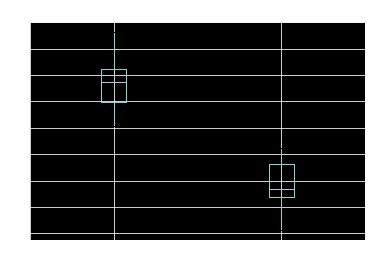

In [ ]:
# Accuracy under attacks is indeed lower !
(pd
 .DataFrame(data=attack_history, columns=['loss', 'accuracy'])
 .boxplot()
 .set_title('Boxplot of metrics under attacked data'));

In [ ]:
ls attacked_data/ | wc -l

3125


In [ ]:
# Create DataFrame for referencing file names
df_images_attacked = \
(df_images
 .copy()
 .assign(image=df_images.image.map(
                             lambda x: 
                             f"{x.split('.')[0]}_attacked.{x.split('.')[1]}")))
df_merged = pd.concat([df_images, df_images_attacked])

In [ ]:
# Cross-validation with TF image API
import sklearn.model_selection
from tensorflow import keras
from tensorflow.keras import layers

n_folds = 3
kf = sklearn.model_selection.KFold(n_splits=n_folds, random_state=seed)
kf.split(df_images)

list_parameters = [0.00001]
model_names = ['adversarial_examples']

list_histories = []

image_folder = 'attacked_data/'
img_width, img_height = 224, 224

epochs = 40
batch_size = 32

for i, model_name in enumerate(model_names):

  # Define loss and optimizer
  loss = keras.losses.BinaryCrossentropy(from_logits=True)
  learning_rate = list_parameters[i]
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  print(f'Training model: {model_name}')
  list_histories = []
  for train_index, test_index in kf.split(df_merged):

    # --- Data processing ---

    df_train = df_merged.iloc[train_index]
    df_test = df_merged.iloc[test_index]
    print('Train shape:', df_train.shape)
    print('Test shape:', df_test.shape)
    
    train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                preprocessing_function=tf.keras.applications.resnet.preprocess_input)
    validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                      preprocessing_function=tf.keras.applications.resnet.preprocess_input)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=image_folder,
        x_col="image",
        y_col="target",
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
        class_mode="binary",
        target_size=(img_width, img_height))

    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=image_folder,
        x_col="image",
        y_col="target",
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
        class_mode="binary",
        target_size=(img_width, img_height))
    
    # --- Model architecture ---

    # Reset graph and seeds
    tf.keras.backend.clear_session()
    reset_random_seeds()

    # Create the base model from the pre-trained model ResNet50
    base_model = tf.keras.applications.ResNet101(
        # input_shape=(128, 128, 3),
                                                  include_top=True,
                                                  weights='imagenet')
    base_model.trainable = True

    head = layers.Flatten()(base_model.output)
    head = layers.Dense(256, kernel_initializer=keras.initializers.glorot_uniform(seed=seed))(head)
    head = layers.Activation('relu')(head)
    # head = layers.Dropout(rate=0.5)(head)

    head = layers.Dense(64, kernel_initializer=keras.initializers.glorot_uniform(seed=seed))(head)
    head = layers.Activation('relu')(head)

    output = layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=seed))(head)
    model = keras.Model(inputs=base_model.inputs, outputs=output)

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    

    nb_train_samples = len(df_train.index)
    nb_validation_samples = len(df_test.index)


    history = model.fit(
      train_generator,
      steps_per_epoch=nb_train_samples // batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=nb_validation_samples // batch_size)
    
    # Append historical training stats
    list_histories.append(history.history)
  # Add it to the dictionnary
  dict_models[model_name] = list_histories
  # Add the last model (could be improved) to the dictionnary
  dict_models[f'{model_name}_model'] = model

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Training model: adversarial_examples
Train shape: (1744, 2)
Test shape: (872, 2)
Found 1744 validated image filenames belonging to 2 classes.
Found 872 validated image filenames belonging to 2 classes.
Epoch 1/40
54/54 [==============================] - 26s 483ms/step - loss: 0.6919 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.5139
Epoch 2/40
54/54 [==============================] - 25s 458ms/step - loss: 0.6858 - accuracy: 0.5047 - val_loss: 0.6932 - val_accuracy: 0.5104
Epoch 3/40
54/54 [==============================] - 25s 460ms/step - loss: 0.6775 - accuracy: 0.5088 - val_loss: 0.6932 - val_accuracy: 0.5127
Epoch 4/40
54/54 [==============================] - 25s 454ms/step - loss: 0.6674 - accuracy: 0.5076 - val_loss: 0.6933 - val_accuracy: 0.5127
Epoch 5/40
54/54 [==============================] - 24s 454ms/step - loss: 0.6570 - accuracy: 0.5035 - val_loss: 0.6930 - val_accuracy: 0.5139
Epoch 6/40
54/54 [==============================] - 25s 455ms/step - loss: 0.6451 -

In [ ]:
# Aggregate all training statisctics !
model_names.append('learning_rate_1e-05')

df = pd.concat(
  [pd.concat([pd.DataFrame(history)
              for history in dict_models[model_name]],
             keys=[f'fold_{i}' for i in range(n_folds)])
   for model_name in model_names],
  keys=model_names)

# Reshaping DataFrame to plot confidence intervals
df =\
(df
  .reset_index()
  .rename(columns={"level_0": "model_name",
                   "level_1": "fold",
                   "level_2": "epochs"},)
  .drop(columns=['fold'])
  .melt(['model_name', 'epochs'],
        var_name='metric_type',
        value_name='value')
  .assign(data_type=lambda s: s.metric_type.map(lambda x: 'validation'
                                              if x.split('_')[0] == 'val' else
                                              'train'))
  .assign(metric_type=lambda s: s.metric_type.str.replace('val_', '')))

df.sample(frac=1).head(10)

,model_name,epochs,metric_type,value,data_type
661,adversarial_examples,21,loss,0.240720,validation
84,learning_rate_1e-05,4,loss,0.596783,train
295,learning_rate_1e-05,15,accuracy,0.996429,train
876,adversarial_examples,36,accuracy,0.971065,validation
122,adversarial_examples,2,loss,0.677512,train
589,learning_rate_1e-05,29,loss,0.421724,validation
474,adversarial_examples,34,accuracy,0.999416,train
210,adversarial_examples,10,loss,0.413120,train
669,adversarial_examples,29,loss,0.176946,validation
187,adversarial_examples,27,loss,0.163792,train


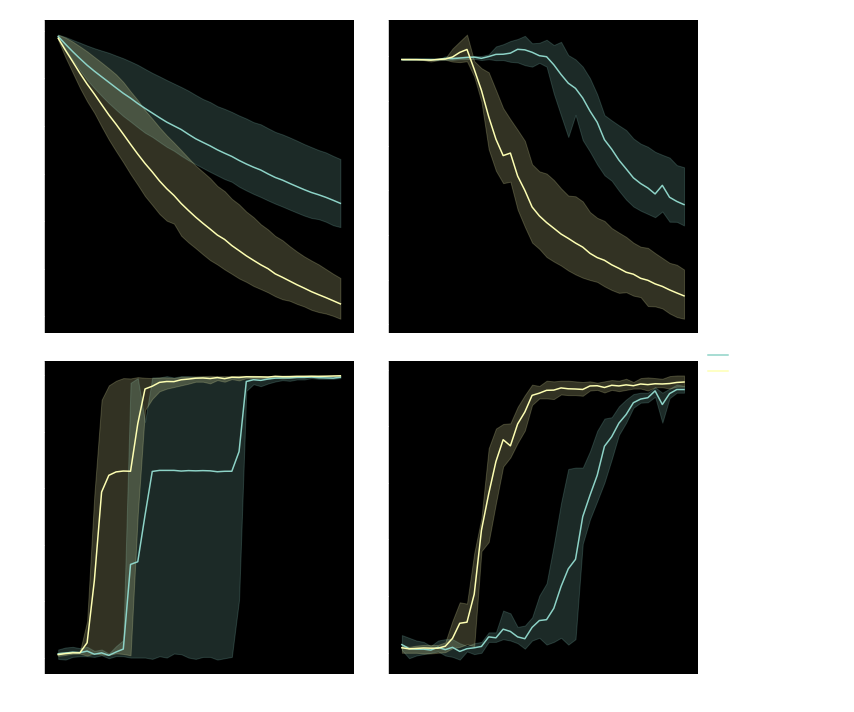

In [ ]:
# Plot training stats with confidence intervals

sns.relplot(x="epochs", y="value",
            col="data_type", row='metric_type', hue="model_name",
            kind="line", data=df , facet_kws={'sharey': False, 'sharex': True})

In [ ]:
(df
 .loc[df.epochs.eq(epochs - 1), :]
 .groupby(['metric_type', 'model_name', 'data_type'])
 .mean())

epochs     value
metric_type model_name           data_type                   
accuracy    adversarial_examples train           39  0.999416
                                 validation      39  0.978009
            learning_rate_1e-05  train           39  0.996825
                                 validation      39  0.964744
loss        adversarial_examples train           39  0.126217
                                 validation      39  0.163819
            learning_rate_1e-05  train           39  0.337552
                                 validation      39  0.368232

### Comments

- Adversarial training helps for generalizing results ! The second fold model might attein the first place in the Zidni competition  (with +98% accuracy).

- Also adversarial training reduce prediction variance since confidence intervals are smaller than those belonging to the original model!

## Testing on hand-labeled data

We have labelled test data provided by Zindi. In this part the model is evaluated against this unknown data.

Warning: in this part you need the *sub_labelized_data.csv* file (hand-labelling) that is available here: https://drive.google.com/file/d/1e0Hh-04ag59H28BH5AVu31fzl4fz47-h/view?usp=sharing

In [ ]:
df_test = pd.read_csv('sub_labelized_data.csv', index_col=0)
df_test.target = df_test.target.astype(str)

In [ ]:
validation_datagen = \
keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=keras.applications.resnet.preprocess_input
    )

test_generator = validation_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=image_folder,
    x_col="image",
    y_col="target",
    batch_size=batch_size,
    shuffle=True,
    seed=seed,
    class_mode="binary",
    target_size=(img_width, img_height))

# Loading the initial model
model = dict_models['learning_rate_1e-05_model']

# Evaluation
model.evaluate(test_generator)

Found 509 validated image filenames belonging to 2 classes.
16/16 [==============================] - 36s 2s/step - loss: 0.3132 - accuracy: 0.9705


[0.31321024894714355, 0.9705304503440857]

## Conclusion

Combining all those techniques would help to obtain a good position in the ladder of the official Spot the Mask Challenge by #ZindiWeekendz (top 10 is slightly above 97%). We have learnt how transfer learning is effective to train classifiers with a small amount of data: lack of data can be filled by direct data augmentation (data processing) and indirect data augmentation (use of a model trained on the ImageNet data to improve performances). Batch normalisation reduce variance of the final estimator while final fully-connected layers dropout is not improving results. 
